### An investigation into why tracks split

I know why, its that the e_cut is too aggressive

Removing it resolves the issue! But thats no good, we need to apply some form of e_cut

In [1]:
import sys,os,os.path
sys.path.append("../../") # if you move files around, you need to adjust this!
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

#%load_ext autoreload
#%autoreload 2
#%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [10, 8]
rcParams['font.size'] = 22

import pandas as pd
import numpy  as np
import tables as tb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as clrs

import IC.invisible_cities.core.core_functions                   as     coref
import IC.invisible_cities.io.dst_io                           as     dstio

from IC.invisible_cities.cities                 import beersheba as beerfun

from IC.invisible_cities.evm.event_model                          import HitCollection

from IC.invisible_cities.database.load_db       import DataSiPM

from IC.invisible_cities.evm.event_model        import Cluster, Hit
from IC.invisible_cities.types.ic_types         import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits, drop_end_point_voxels, make_track_graphs, get_track_energy

from IC.invisible_cities.evm.event_model        import HitEnergy
from IC.invisible_cities.cities.beersheba          import DeconvolutionMode
from IC.invisible_cities.cities.beersheba          import CutType

from IC.invisible_cities.reco import hits_functions as hif

from IC.invisible_cities.reco.deconv_functions import deconvolve
from IC.invisible_cities.reco.deconv_functions import deconvolution_input
from IC.invisible_cities.reco.deconv_functions import InterpolationMethod

import IC.invisible_cities.io.mcinfo_io as mcio

from collections import defaultdict

import matplotlib.cm as cm
from matplotlib.colors import Normalize



def threshold_hits(threshold_charge, same_peak, hitc):
    """
    Applies a threshold to hits and redistributes the charge/energy.

    Parameters
    ----------
    threshold_charge : float
        minimum pes of a hit
    same_peak        : bool
        whether to reassign NN hits' energy only to the hits from the same peak

    Returns
    ----------
    A function that takes HitCollection as input and returns another object with
    only non NN hits of charge above threshold_charge.
    The energy of NN hits is redistributed among neighbors.
    """

    t = hitc.time
    thr_hits = hif.threshold_hits(hitc.hits, threshold_charge     )
    mrg_hits = hif.merge_NN_hits ( thr_hits, same_peak = same_peak)

    cor_hits = []
    for hit in mrg_hits:
        cluster = Cluster(hit.Q, xy(hit.X, hit.Y), hit.var, hit.nsipm)
        xypos   = xy(hit.Xpeak, hit.Ypeak)
        hit     = Hit(hit.npeak, cluster, hit.Z, hit.E, xypos, hit.Ec)
        cor_hits.append(hit)

    new_hitc      = HitCollection(hitc.event, t)
    new_hitc.hits = cor_hits
    return new_hitc





def hits_from_df (dst, skip_NN = False):
    """
    Function that transforms pandas DataFrame dst to HitCollection
    ------
    Parameters
    ------
    dst : pd.DataFrame
        DataFrame with obligatory columns :
                event, npeak, X, Y, Z,  Q, E
        If time, nsipm, Xrms, Yrms, Qc, Ec, track_id are not
        inside dst the default value is set to -1
        If Xpeak, Ypeak not in dst the default value is -1000
    ------
    Returns
    ------
    Dictionary {event_number : HitCollection}
    from here
    https://github.com/next-exp/IC/blob/v2-development/invisible_cities/io/hits_io.py#L16
    """
    all_events = {}
    times = getattr(dst, 'time', [-1]*len(dst))
    for (event, time) , df in dst.groupby(['event', times]):
        #pandas is not consistent with numpy dtypes so we have to change it by hand
        event = np.int32(event)
        hits  = []
        for i, row in df.iterrows():
            Q = getattr(row,'Q', row.E)
            if skip_NN and Q == NN:
                continue
            if hasattr(row, 'Xrms'):
                Xrms  = row.Xrms
                Xrms2 = Xrms**2
            else:
                Xrms = Xrms2 = -1
            if hasattr(row, 'Yrms'):
                Yrms  = row.Yrms
                Yrms2 = Yrms**2
            else:
                Yrms = Yrms2 = -1
            nsipm   = getattr(row, 'nsipm'   , -1   )     # for backwards compatibility
            Qc      = getattr(row, 'Qc'      , -1   )     # for backwards compatibility
            Xpeak   = getattr(row, 'Xpeak'   , -1000)     # for backwards compatibility
            Ypeak   = getattr(row, 'Ypeak'   , -1000)     # for backwards compatibility
            Ec      = getattr(row, 'Ec'      , -1   )     # for backwards compatibility
            trackID = getattr(row, 'track_id', -1   )     # for backwards compatibility
            Ep      = getattr(row, "Ep"      , -1   )     # for backwards compatibility

            hit = Hit(row.npeak            ,
                      Cluster(Q               ,
                              xy(row.X, row.Y),
                              xy(Xrms2, Yrms2),
                              nsipm = nsipm   ,
                              z     = row.Z   ,
                              E     = row.E   ,
                              Qc    = Qc      ),
                      row.Z                ,
                      row.E                ,
                      xy(Xpeak, Ypeak)     ,
                      s2_energy_c = Ec     ,
                      track_id    = trackID,
                      Ep          = Ep     )

            hits.append(hit)

        if len(hits):
            all_events[event] = HitCollection(event, time, hits=hits)

    return all_events

def hitc_to_df_(hitc):
    columns = defaultdict(list)
    for hit in hitc.hits:
        columns["event"   ].append(hitc.event)
        columns["time"    ].append(hitc.time)
        columns["npeak"   ].append(hit .npeak)
        columns["Xpeak"   ].append(hit .Xpeak)
        columns["Ypeak"   ].append(hit .Ypeak)
        columns["nsipm"   ].append(hit .nsipm)
        columns["X"       ].append(hit .X)
        columns["Y"       ].append(hit .Y)
        columns["Xrms"    ].append(hit .Xrms)
        columns["Yrms"    ].append(hit .Yrms)
        columns["Z"       ].append(hit .Z)
        columns["Q"       ].append(hit .Q)
        columns["E"       ].append(hit .E)
        columns["Qc"      ].append(hit .Qc)
        columns["Ec"      ].append(hit .Ec)
        columns["track_id"].append(hit .track_id)
        columns["Ep"      ].append(hit .Ep)
    return pd.DataFrame(columns)






def soph_to_lowTh(df, threshold = 5):
    '''
    Converts sophronia 'RECO/Events' to lowTh events via a rather convoluted process
    Made by me (John Waiton), so dont treat it like a normal function from IC!
    ------
    Parameters
    ------
    df : pd.DataFrame
        DataFrame with obligatory columns :
                event, npeak, X, Y, Z,  Q, E
    threshold: int
        value at which the threshold is set.
    ------
    Returns
    ------
    Dictionary {event_number : HitCollection}
    from here
    '''

    # safety check, to ensure you don't accidentally make a repeating dataframe
    


    # new parameters for threshold, this is silly but I'm copying previous convention
    pes = 1
    threshold = threshold * pes
    same_peak = True

    # convert sophronia RECO/Events to hit collection
    soph_hitc = hits_from_df(df)

    # collect the keys as the event numbers
    soph_hitc_list = list(soph_hitc.keys())

    print("Processing data...")
    # loop over all of these events
    j = 0
    for i in soph_hitc_list:
        j += 1

        if (len(soph_hitc_list)%j == 50): 
            print("{}/{}".format(j, len(soph_hitc_list)))
        # choose i'th event
        soph_hit_event = soph_hitc.get(i)

        # Apply threshold calculation
        soph_hitc_lowTh = threshold_hits(threshold, same_peak, soph_hit_event)

        # convert back to pandas dataframe using hitc_to_df
        soph_hdst_lowTh = hitc_to_df_(soph_hitc_lowTh)

        # check if pandas dataframe with all the events exists yet
        if 'full_soph_df' in locals() and isinstance(full_soph_df, pd.DataFrame):
            full_soph_df = pd.concat([full_soph_df, soph_hdst_lowTh])
        else:
            full_soph_df = soph_hdst_lowTh.copy(deep = True)
    
    return full_soph_df



### FILE AND LIMIT TOGGLE

In [2]:
# loading sophronia file
#soph_file = f'../../../next_misc/Tl_studies/sophronia/sophronia_qthr2.h5'
soph_file = f'/home/e78368jw/Documents/NEXT_CODE/next_misc/energy_topology_study/testing_data/sophronia_27_208Tl.h5'
soph_hdst = dstio.load_dst(soph_file, 'RECO', 'Events')#CHITS/lowTh

# Name of directory the plots are going into
#pre_dir_name = 'qthr2_plot/'

# set q_thr value here
thresh = 4

# Decides if plots are limited by the MC true info
lim_toggle = True


# limits
limit_spacing = 50 # put in the number required division-wise to produce a percentage
                    # eg: 10% of min and max means /10, 50% means /2

display(soph_hdst)

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,520000,5.200012e+11,0,237.823620,-217.509278,1,225.475,-225.475,0.0,0.0,369.512128,5.101449,236.734026,-1.0,0.000766,-1,-1.0
1,520000,5.200012e+11,0,237.823620,-217.509278,1,225.475,-209.925,0.0,0.0,369.512128,10.144928,470.777938,-1.0,0.001512,-1,-1.0
2,520000,5.200012e+11,0,237.823620,-217.509278,1,241.025,-241.025,0.0,0.0,369.512128,4.811594,223.283232,-1.0,0.000741,-1,-1.0
3,520000,5.200012e+11,0,237.823620,-217.509278,1,241.025,-225.475,0.0,0.0,369.512128,13.913044,645.638310,-1.0,0.002115,-1,-1.0
4,520000,5.200012e+11,0,237.823620,-217.509278,1,241.025,-209.925,0.0,0.0,369.512128,18.144928,842.019953,-1.0,0.002748,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147151,520640,5.206420e+11,1,347.356042,323.206374,1,349.875,318.775,0.0,0.0,670.050544,5.913043,188.888896,-1.0,0.000849,-1,-1.0
147152,520640,5.206420e+11,1,347.356042,323.206374,1,349.875,334.325,0.0,0.0,670.050544,5.275362,168.518515,-1.0,0.000608,-1,-1.0
147153,520640,5.206420e+11,1,347.356042,323.206374,1,365.425,318.775,0.0,0.0,670.050544,6.492754,207.407411,-1.0,0.001296,-1,-1.0
147154,520640,5.206420e+11,1,347.356042,323.206374,1,365.425,334.325,0.0,0.0,670.050544,4.521739,144.444446,-1.0,0.000521,-1,-1.0


In [3]:
soph_lowTh = soph_to_lowTh(soph_hdst, threshold = thresh)


Processing data...
133/316
266/316


### beersheba params

In [4]:
# Input file and some event IDs to look at.
dist = 12
typefile = 'esmeralda' #'esmeralda'
#file = f'/Users/halmamol/NEXT/files/NEXT100/separated/esmeralda/esmeralda_10_sep.h5'
#file = f'../../../Tl_studies/LPR/208Tl/PORT_2a/prod/esmeralda/esmeralda_180_208Tl.h5'
#file = f'/Users/halmamol/NEXT/files/FLEX/ELdistMask/Xe/bb0nu/{typefile}/NextFlex.bb0nu.FLEXELdist{dist}mask.0.detsim.h5'
evts = [90] #15, 30, 90
pitch = 15.55
detector_db     = 'localdb.NEXT100DB.sqlite3'
run_number      = -1

datatype = 'MC'


# Parameters involved in beersheba city and the deconvolution.

'''
## FROM OLD TESTING
deconv_params = dict(
  q_cut           = 5, #5 for 6mm  - 5 for 6mm
  drop_dist       = [16, 16],
  #psf_fname       = f'/Users/halmamol/NEXT/PSF_FLEX100_mask{dist}_lowQE.h5',     
  psf_fname       = f'../data/data/LightTables/NEXT100_PSF_kr83m.h5',     
  e_cut           = 6e-3, #15 for 6mm  - 15 for 6mm
  n_iterations    = 100, #150 for 6mm  - 150 for 6mm
  iteration_tol   = 1e-10,
  sample_width    = [15.55, 15.55],
  bin_size        = [ 1,  1],
  diffusion       = (1., 0.2),
  n_dim           = 2,
  deconv_mode     = DeconvolutionMode.joint)#,
 # energy_type     = HitEnergy.Ec,
 # cut_type        = CutType.abs,
 # inter_method    = InterpolationMethod.cubic)
'''

# new parameters for threshold
pes = 1
threshold = thresh * pes
same_peak = True

deconv_params = dict(
                  drop_dist       = [16., 16.],
                  psf_fname       = f'/home/e78368jw/Documents/NEXT_CODE/Tl_studies/LPR/LightTables/NEXT100_PSF_kr83m_5bar.h5',
                  q_cut           = thresh,                   # WE HAVE MANUALLY CHANGED THIS FROM 10 -> 5 HERE
                  e_cut           = 9e-3,                # WE HAVE MANUALLY CHANGED THIS FROM 12e-3 TO 6e-3
                  n_iterations    = 155,
                  iteration_tol   = 1e-10,
                  sample_width    = [15.55, 15.55],
                  bin_size        = [ 1.,  1.],
                  satellite_iter  = 1,
                  satellite_dist  = 2,
                  satellite_size  = 10,
                  energy_type     = HitEnergy.Ec,               #Removing these variables because they were previously? 
                  diffusion       = (1.440, 1.440),
                  deconv_mode     = DeconvolutionMode.joint,
                  n_dim           = 2,
                  cut_type        = CutType.abs,              #Removing these variables because they were previously?
                  inter_method    = InterpolationMethod.cubic)            #Removing these variables because they were previously?  




#DeconvolutionMode
                
deconv_params_   = {k : v for k, v in deconv_params.items() if k not in ['q_cut', 'drop_dist']}

# Couple of functions used in beersheba.
cut_sensors       = beerfun.cut_over_Q   (deconv_params['q_cut'    ], ['E', 'Ec'])
drop_sensors      = beerfun.drop_isolated(deconv_params['drop_dist'], ['E', 'Ec'])

In [5]:
hdst = soph_lowTh

signal_evts = np.load('port_1a_signal_evts.npy')
# events that are signals in this file
print([x for x in np.unique(hdst.event.values)/2 if x in signal_evts])

[260007.0, 260016.0, 260025.0, 260030.0, 260033.0, 260035.0, 260038.0, 260067.0, 260068.0, 260082.0, 260086.0, 260092.0, 260111.0, 260120.0, 260135.0, 260145.0, 260164.0, 260170.0, 260177.0, 260229.0, 260230.0, 260235.0, 260236.0, 260272.0, 260277.0, 260290.0, 260294.0, 260298.0, 260300.0, 260302.0]


In [6]:

# select event, preferably a signal event.
evt  = hdst.event.unique()[7]
print(evt)
print(evt/2)
hits = hdst[hdst.event == evt]

file_number = 27
dir_name = "Tl208_" + str(file_number) + "_event_" + str(int(evt/2))


520014
260007.0


In [7]:
x_range = (hits.X.max()-hits.X.min())/2.
y_range = (hits.Y.max()-hits.Y.min())/2.
z_range = (hits.Z.max()-hits.Z.min())/2.
mid_x   = (hits.X.max()+hits.X.min())/2.
mid_y   = (hits.Y.max()+hits.Y.min())/2.
mid_z   = (hits.Z.max()+hits.Z.min())/2.
min_x = hits.X.min()
min_y = hits.Y.min()
min_z = hits.Z.min()

max_x = hits.X.max()
max_y = hits.Y.max()
max_z = hits.Z.max()
print("X maximum and minimum")
print(max_x, min_x)
print("")

print("Y maximum and minimum")
print(max_y, min_y)
print("")

print("Z maximum and minimum")
print(max_z, min_z)

xbins = int(hits.X.max()-hits.X.min())
ybins = int(hits.Y.max()-hits.Y.min())
zbins = int((hits.Z.max()-hits.Z.min())/2.)

X maximum and minimum
443.175 -272.125

Y maximum and minimum
225.475 -396.525

Z maximum and minimum
300.13301718750006 250.91151093750003


In [8]:
# z slices near maximum z
z_slices = np.sort(np.unique(hits.Z.to_numpy()))
for i in range(len(z_slices)):
    print(str.format('{}', str(z_slices[i])))
#print(z_slices[-3:])
# z value to take above for true information plotting
z_limit = z_slices[-16]#(z_slices[-2] - z_slices[-3])/2 + z_slices[-3]
#print(z_limit)

spacing = (z_slices[1] - z_slices[0]) / 2
#print(spacing)

250.91151093750003
253.76459062500004
256.8430921875
260.1354328125
263.113528125
266.19642656250005
269.28257343750005
272.41895625000006
275.49079687500006
278.50396875
281.64671718750003
285.15640781250005
288.40724062500004
291.46152656250007
294.54120937500005
297.344775
300.13301718750006


In [9]:
if (datatype == 'MC'):
    evtmap = mcio.load_eventnumbermap(soph_file).set_index('nexus_evt')
    true_info = mcio.load_mchits_df(soph_file).reset_index()
    true_info.event_id = true_info.event_id.map(evtmap.evt_number)
    
    
    this_evt_true_info = true_info[true_info.event_id == evt]

    xt = this_evt_true_info.x
    yt = this_evt_true_info.y
    zt = this_evt_true_info.z
    et = this_evt_true_info.energy*1000

In [10]:

df_ps = pd.read_hdf(soph_file, 'MC/particles')
df_ps = df_ps[df_ps.event_id == evt/2]

def return_id(number):
    return str(df_ps[df_ps.particle_id == number].particle_name.values).strip("'[]'")

#df_ps = pd.read_hdf(soph_file, 'MC/particles')
#df_ps = df_ps[df_ps.event_id == evt/2]
#display(str(df_ps[df_ps.particle_id == 40].particle_name.values).strip("'[]'"))
#display(this_evt_true_info)
#display(df_ps.head(50))

#for pid, df in this_evt_true_info.groupby('particle_id'):
this_evt_true_info['particle_name'] = this_evt_true_info['particle_id'].apply(return_id)
display(this_evt_true_info)

/tmp/ipykernel_40990/680514964.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_evt_true_info['particle_name'] = this_evt_true_info['particle_id'].apply(return_id)


,event_id,particle_id,hit_id,x,y,z,time,energy,label,particle_name
2873,520014,26,0,182.407074,-119.473282,271.677399,2.225528,0.000019,ACTIVE,Xe131
2874,520014,25,0,181.922989,-120.064018,271.036713,2.060107,0.001491,ACTIVE,e+
2875,520014,25,1,181.484909,-120.611244,270.343353,2.063638,0.000316,ACTIVE,e+
2876,520014,25,2,181.138397,-121.226753,269.655487,2.067169,0.003888,ACTIVE,e+
2877,520014,25,3,180.685638,-121.794159,268.988434,2.070701,0.001564,ACTIVE,e+
...,...,...,...,...,...,...,...,...,...,...
3390,520014,44,7,139.916702,-95.556442,268.934570,2.396790,0.001756,ACTIVE,e-
3391,520014,44,8,139.881714,-95.578346,268.939453,2.397384,0.001486,ACTIVE,e-
3392,520014,44,9,139.872070,-95.598763,268.912354,2.397916,0.007674,ACTIVE,e-
3393,520014,44,10,139.872757,-95.598480,268.902618,2.398144,0.003133,ACTIVE,e-


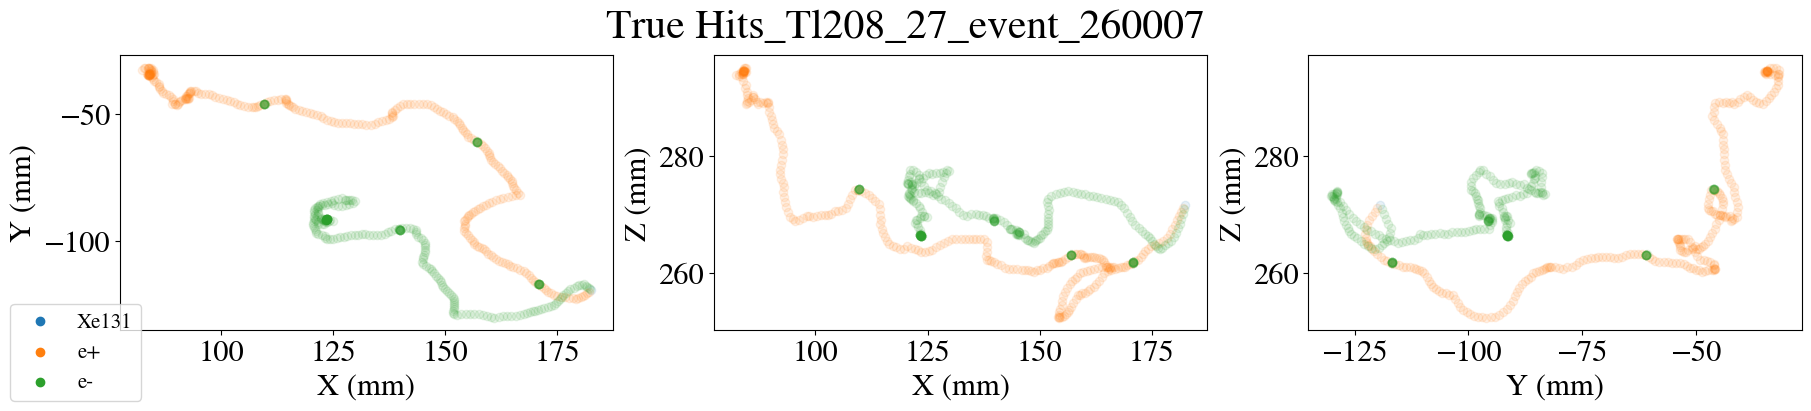

In [11]:
from matplotlib.lines import Line2D




fig, axes = plt.subplots(1, 3, figsize=(18, 4), constrained_layout=True)
fig.suptitle('True Hits_' + dir_name, fontsize=30)
#fig.tight_layout()
added_labels = set()
# Dictionary to store custom handles for the legend
legend_handles = {}
for pid, df in this_evt_true_info.groupby('particle_name'):

    xt = df.x
    yt = df.y
    zt = df.z
    et = df.energy*1000


    axes[0].scatter(xt, yt,  alpha=0.1, label = str(pid))
    axes[1].scatter(xt, zt,  alpha=0.1, label = str(pid))
    axes[2].scatter(yt, zt,  alpha=0.1, label = str(pid))


    axes[0].set_xlabel('X (mm)');
    axes[0].set_ylabel('Y (mm)');
    axes[1].set_xlabel('X (mm)');
    axes[1].set_ylabel('Z (mm)');
    axes[2].set_xlabel('Y (mm)');
    axes[2].set_ylabel('Z (mm)');

# Retrieve legend handles and labels
handles, labels = axes[0].get_legend_handles_labels()

# Create a single legend for all subplots
legend = fig.legend(handles, labels, fontsize=15, loc = 'lower left')
for handle in legend.legendHandles:
    handle.set_alpha(1.0)

plt.show()

Text(0.5, 0.98, 'SiPM Hits_Tl208_27_event_260007')

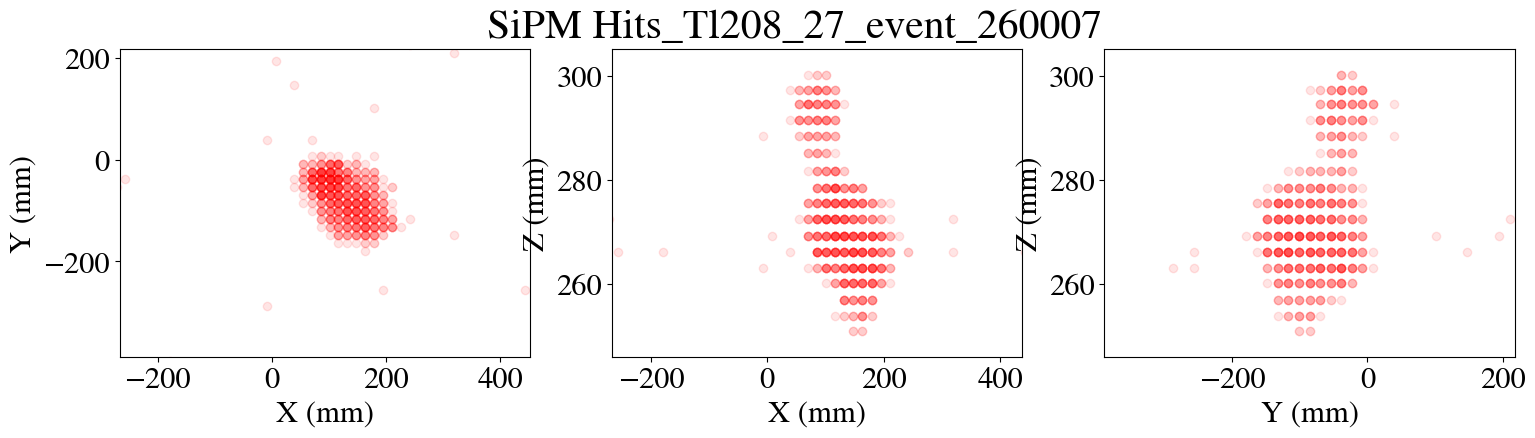

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
axes[0].scatter(hits.X, hits.Y,  alpha=0.1, color='red')
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].scatter(hits.X, hits.Z,  alpha=0.1, color='red')
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');

axes[2].scatter(hits.Y, hits.Z,  alpha=0.1, color='red')
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');


if lim_toggle == True:
    axes[0].set_xlim([min_x - min_x/limit_spacing, max_x + max_x/limit_spacing])
    axes[0].set_ylim([min_y - min_y/limit_spacing, max_y + min_y/limit_spacing])

    axes[1].set_xlim([min_x - min_x/limit_spacing, max_x + min_x/limit_spacing])
    axes[1].set_ylim([min_z - min_z/limit_spacing, max_z + min_z/limit_spacing])

    axes[2].set_xlim([min_y - min_y/limit_spacing, max_y + min_y/limit_spacing])
    axes[2].set_ylim([min_z - min_z/limit_spacing, max_z + min_z/limit_spacing])

    

fig.suptitle('SiPM Hits_' + dir_name, fontsize=30)

#### plot the Z slice I have interest in

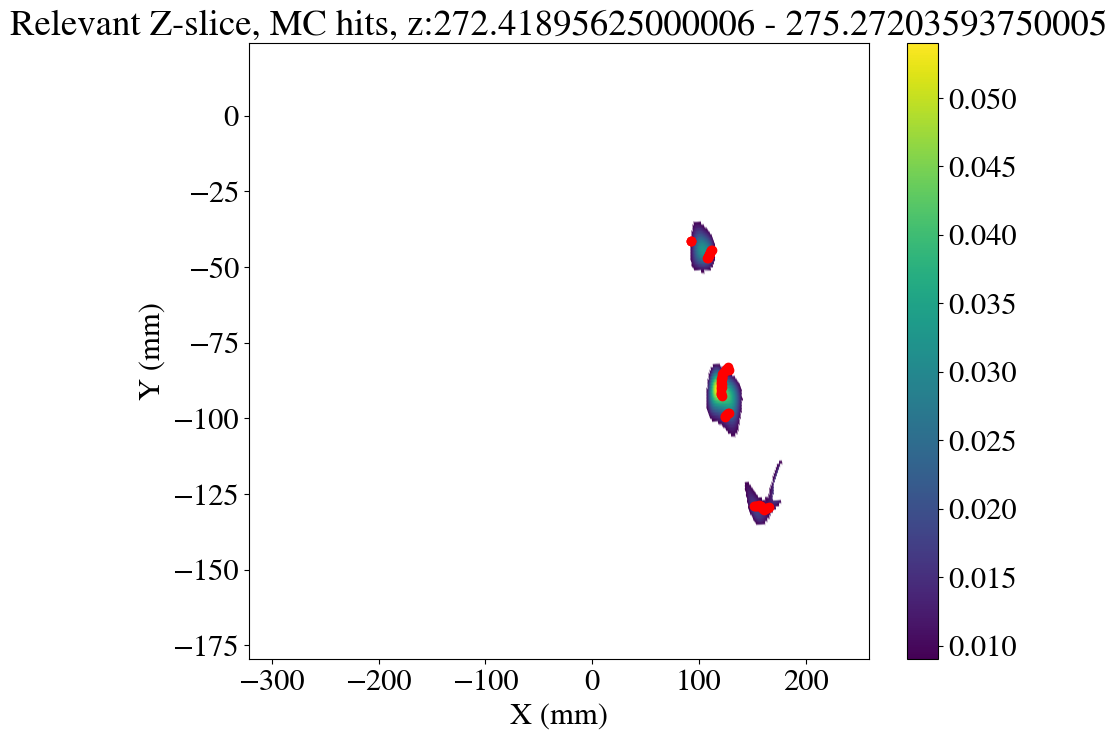

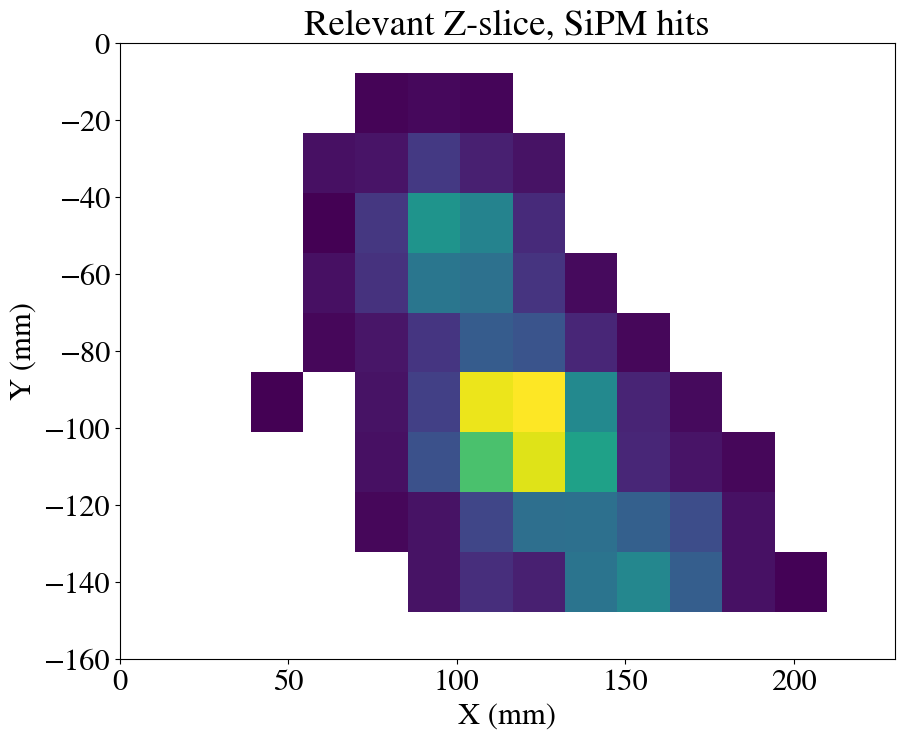

277.6793212890625
-147.725


In [29]:
z_interest = 272.41895625000006#256.8430921875
z_low = z_interest
z_high = z_interest + spacing*2

preloaded = True#False#True
if (preloaded == True):
    inter_pos_0 = np.load('inter_pos_0.npy')
    inter_pos_1 = np.load('inter_pos_1.npy')
    #inter_sig = np.load('inter_sig.npy')
    inter_sig = np.load('inter_post_deco.npy')
    my_cmap = cm.get_cmap("viridis").with_extremes(under = "white")

    r = plt.scatter(inter_pos_0, inter_pos_1, c = inter_sig, vmin = 9e-3, cmap=my_cmap)
    plt.colorbar(r)

Z_relevant_hits = this_evt_true_info[this_evt_true_info.z > z_low]
Z_relevant_hits = Z_relevant_hits[Z_relevant_hits.z < z_high]
x_vals = Z_relevant_hits.x
y_vals = Z_relevant_hits.y
plt.scatter(x_vals, y_vals, alpha=1, color='red')


#plt.xlim([21, 129])
#plt.ylim([15, -110])
#plt.gca().invert_yaxis()
plt.xlabel('X (mm)');
plt.ylabel('Y (mm)');
plt.title("Relevant Z-slice, MC hits, z:" + str(z_low) +  " - " + str(z_high))
plt.show()

Z_relevant_hits = hits[hits.Z == z_interest]
x_vals = Z_relevant_hits.X
y_vals = Z_relevant_hits.Y
q_vals = Z_relevant_hits.Q
xx = np.arange(Z_relevant_hits.X.min(), Z_relevant_hits.X.max() + pitch, pitch)
yy = np.arange(Z_relevant_hits.Y.min(), Z_relevant_hits.Y.max() + pitch, pitch)

plt.hist2d(x_vals, y_vals, bins=[xx, yy], weights=q_vals, cmin=0.0001);
plt.xlabel('X (mm)');
plt.ylabel('Y (mm)');
plt.xlim([0, 230])
plt.ylim([-160, 0])
plt.title("Relevant Z-slice, SiPM hits")
plt.show()

print(zt.max())
print(y_vals.min())

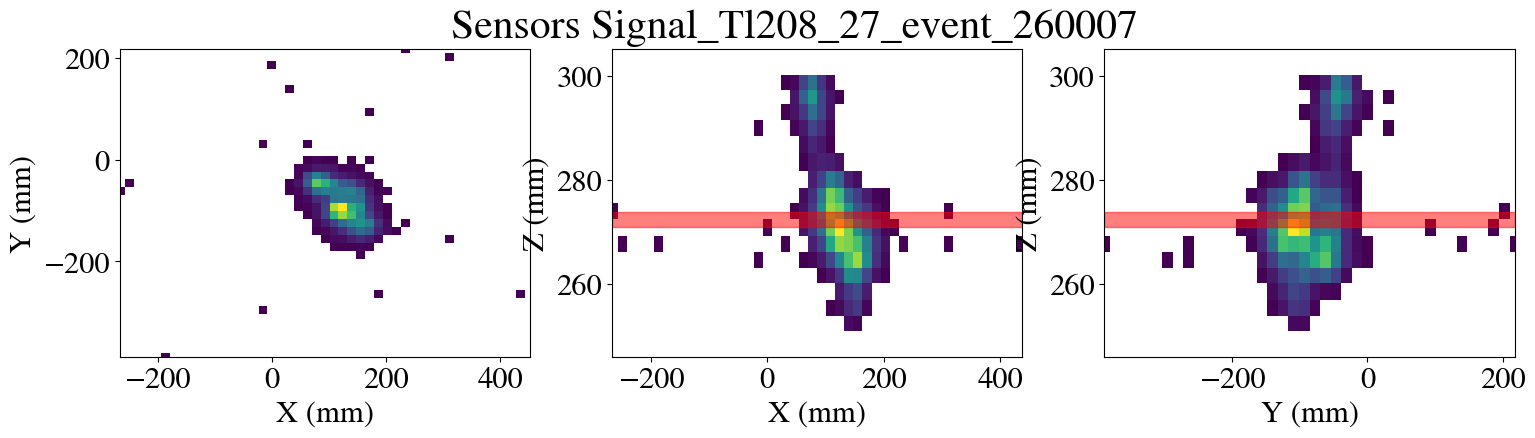

In [14]:
# then applying transformations to convert to 'SiPM outputs'
fig, axes = plt.subplots(1, 3, figsize=(18, 4))


xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
zz = hits.Z.unique()

axes[0].hist2d(hits.X, hits.Y, bins=[xx, yy], weights=hits.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits.X, hits.Z, bins=[xx, zz], weights=hits.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');
axes[1].axhspan(272.41895625 - spacing, 272.41895625 + spacing, color = 'red', alpha = 0.5)


axes[2].hist2d(hits.Y, hits.Z, bins=[yy, zz], weights=hits.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');
axes[2].axhspan(272.41895625 - spacing, 272.41895625 + spacing, color = 'red', alpha = 0.5)

fig.suptitle('Sensors Signal_' + dir_name, fontsize=30)


if lim_toggle == True:
    axes[0].set_xlim([min_x - min_x/limit_spacing, max_x + max_x/limit_spacing])
    axes[0].set_ylim([min_y - min_y/limit_spacing, max_y + min_y/limit_spacing])

    axes[1].set_xlim([min_x - min_x/limit_spacing, max_x + min_x/limit_spacing])
    axes[1].set_ylim([min_z - min_z/limit_spacing, max_z + min_z/limit_spacing])

    axes[2].set_xlim([min_y - min_y/limit_spacing, max_y + min_y/limit_spacing])
    axes[2].set_ylim([min_z - min_z/limit_spacing, max_z + min_z/limit_spacing])

    

In [15]:
hits_cut = coref.timefunc(cut_sensors)(hits.copy())

Time spent in cut_over_Q: 0.011486053466796875 s


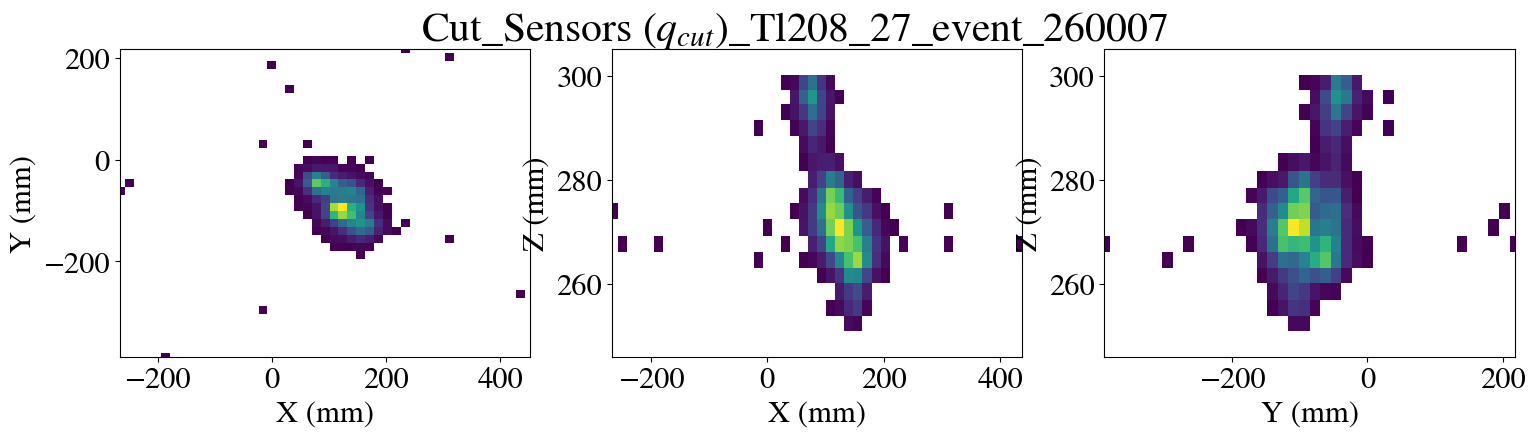

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
zz = hits.Z.unique()

axes[0].hist2d(hits_cut.X, hits_cut.Y, bins=[xx, yy], weights=hits_cut.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_cut.X, hits_cut.Z, bins=[xx, zz], weights=hits_cut.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


axes[2].hist2d(hits_cut.Y, hits_cut.Z, bins=[yy, zz], weights=hits_cut.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');


fig.suptitle('Cut_Sensors ($q_{cut}$)_' + dir_name, fontsize=30)


if lim_toggle == True:
    axes[0].set_xlim([min_x - min_x/limit_spacing, max_x + max_x/limit_spacing])
    axes[0].set_ylim([min_y - min_y/limit_spacing, max_y + min_y/limit_spacing])

    axes[1].set_xlim([min_x - min_x/limit_spacing, max_x + min_x/limit_spacing])
    axes[1].set_ylim([min_z - min_z/limit_spacing, max_z + min_z/limit_spacing])

    axes[2].set_xlim([min_y - min_y/limit_spacing, max_y + min_y/limit_spacing])
    axes[2].set_ylim([min_z - min_z/limit_spacing, max_z + min_z/limit_spacing])

    

In [17]:
hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())

Time spent in drop_isolated: 0.010313749313354492 s


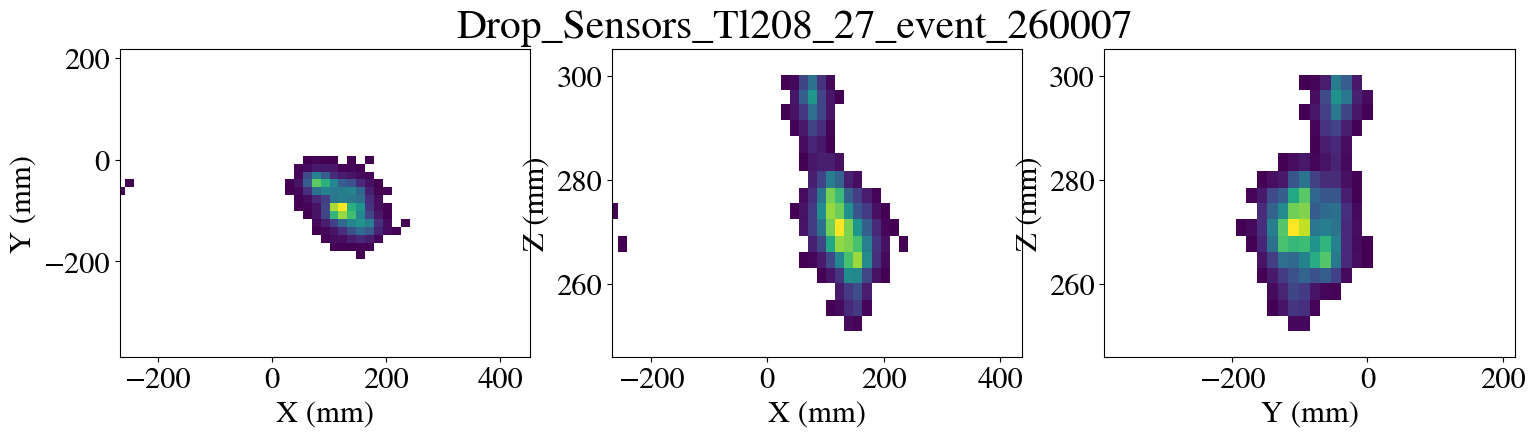

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
zz = hits.Z.unique()

axes[0].hist2d(hits_drop.X, hits_drop.Y, bins=[xx, yy], weights=hits_drop.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_drop.X, hits_drop.Z, bins=[xx, zz], weights=hits_drop.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


axes[2].hist2d(hits_drop.Y, hits_drop.Z, bins=[yy, zz], weights=hits_drop.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

fig.suptitle('Drop_Sensors_' + dir_name, fontsize=30)

if lim_toggle == True:
    axes[0].set_xlim([min_x - min_x/limit_spacing, max_x + max_x/limit_spacing])
    axes[0].set_ylim([min_y - min_y/limit_spacing, max_y + min_y/limit_spacing])

    axes[1].set_xlim([min_x - min_x/limit_spacing, max_x + min_x/limit_spacing])
    axes[1].set_ylim([min_z - min_z/limit_spacing, max_z + min_z/limit_spacing])

    axes[2].set_xlim([min_y - min_y/limit_spacing, max_y + min_y/limit_spacing])
    axes[2].set_ylim([min_z - min_z/limit_spacing, max_z + min_z/limit_spacing])

    


take the x,y interpolate it

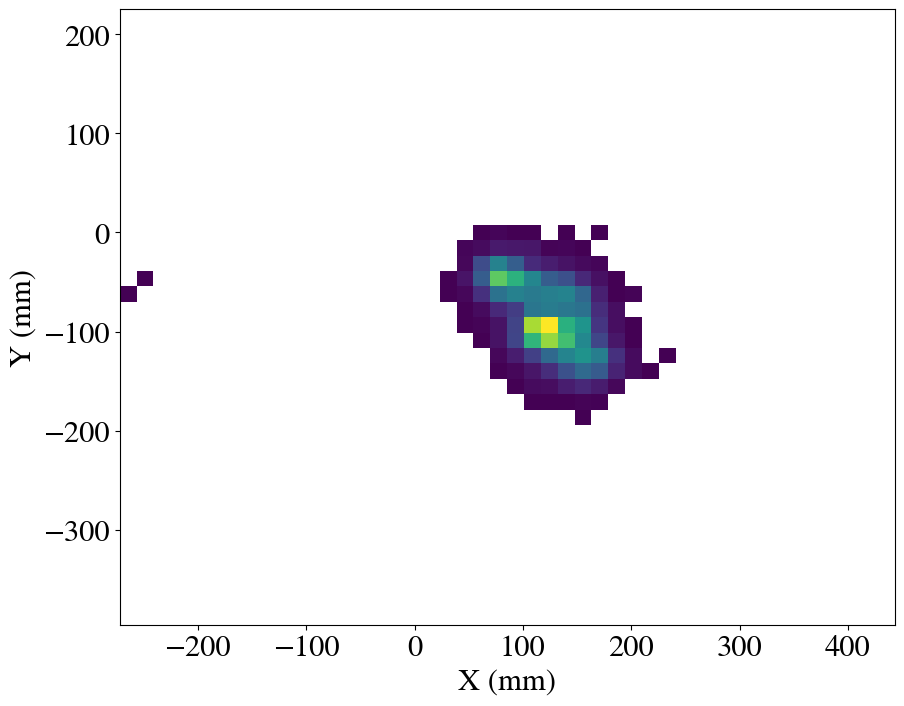

In [19]:
xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
zz = hits.Z.unique()

plt.hist2d(hits_drop.X, hits_drop.Y, bins=[xx, yy], weights=hits_drop.Q, cmin=0.0001);
plt.xlabel('X (mm)');
plt.ylabel('Y (mm)');

#data = 

#allbins   = [np.arange(rang[0], rang[1] + np.finfo(np.float32).eps, sw) for rang, sw in zip(ranges, sample_width)]
#Hs, edges = np.histogramdd(data, bins=allbins, normed=False, weights=weight)

In [20]:
print([str(x) for x in np.unique(hits_drop.Z.to_numpy())])


['250.91151093750003', '253.76459062500004', '256.8430921875', '260.1354328125', '263.113528125', '266.19642656250005', '269.28257343750005', '272.41895625000006', '275.49079687500006', '278.50396875', '281.64671718750003', '285.15640781250005', '288.40724062500004', '291.46152656250007', '294.54120937500005', '297.344775', '300.13301718750006']


In [21]:
import importlib
importlib.reload(beerfun)

<module 'IC.invisible_cities.cities.beersheba' from '/home/e78368jw/Documents/NEXT_CODE/next_misc/energy_topology_study/../../IC/invisible_cities/cities/beersheba.py'>

In [22]:
# this is to stop your number of iterations vanishing because of the below function, as you're rewriting deconv_params_
if 'save_state' in locals():
    deconv_params_['n_iterations'] = save_state
else:
    # first time round, so set it
    save_state = deconv_params_['n_iterations']
print(save_state)

155


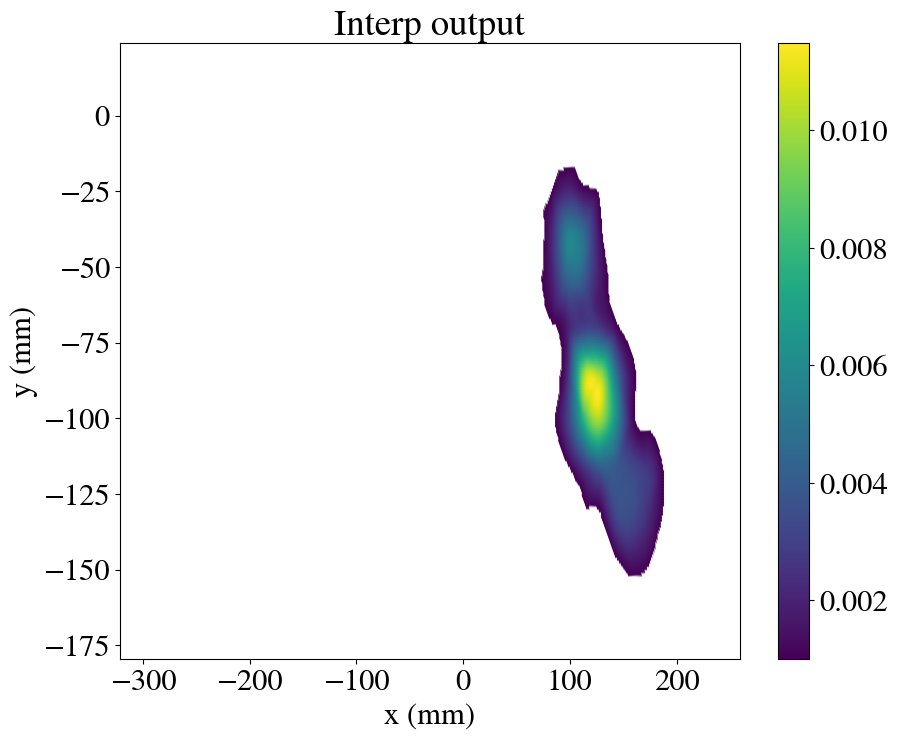

Time spent in apply_deconvolution: 276.21852254867554 s


In [23]:


# one run
deconv_params_['satellite_iter'] = 1
deconv_params_['n_iterations'] = 150
deconvolver = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_)
hits_deco = coref.timefunc(deconvolver)(hits_drop.copy())



In [ ]:
'''
iter_E = []
iter_no = []
i = 0
p = 0
for iterN in np.arange(5, deconv_params_['n_iterations'], 5):
    deconv_params_['n_iterations'] = iterN
    deconvolver = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_)
    print(f'{iterN} iterations')


    # using the same X-Y-Z from hits_drop
    if (i == 0):
        xx = np.arange(hits_drop.X.min(), hits_drop.X.max())
        yy = np.arange(hits_drop.Y.min(), hits_drop.Y.max())
        zz = hits_drop.Z.unique()
        i += 1

    hits_deco = coref.timefunc(deconvolver)(hits_drop.copy())
    
        
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))

    axes[0].hist2d(hits_deco.X, hits_deco.Y, bins=[xx, yy], weights=hits_deco.E*1000, cmin=0.0001);
    if (datatype == 'MC'):
        axes[0].scatter(xt, yt,  alpha=0.01, color='red')
    axes[0].set_xlabel('X (mm)');
    axes[0].set_ylabel('Y (mm)');

    axes[1].hist2d(hits_deco.X, hits_deco.Z, bins=[xx, zz], weights=hits_deco.E*1000, cmin=0.0001);
    if (datatype == 'MC'):
        axes[1].scatter(xt, zt,  alpha=0.01, color='red')
    axes[1].set_xlabel('X (mm)');
    axes[1].set_ylabel('Z (mm)');

    axes[2].hist2d(hits_deco.Y, hits_deco.Z, bins=[yy, zz], weights=hits_deco.E*1000, cmin=0.0001);
    if (datatype == 'MC'):
        axes[2].scatter(yt, zt,  alpha=0.01, color='red')
    
    axes[2].set_xlabel('Y (mm)');
    axes[2].set_ylabel('Z (mm)');


    fig.suptitle('deconvolved_with_MC_' + str(int(evt/2)) + "_iteration " + str(iterN), fontsize=30)
    fig.savefig('/home/e78368jw/Documents/NEXT_CODE/next_misc/energy_topology_study/plots_dodgy_events/dodgy_event_deconv/' + str(evt/2) + '_dodgy_iter_' + str(iterN) + '.png')
    plt.close(fig)

    # lets also collect the energy distribution over these iterations.
    #plt.hist(hits_deco.E.values, bins = 30)
    #plt.title('deconv_hits_' + str(int(evt/2))+ "_iteration " + str(iterN), fontsize=30)
    #plt.xlabel("Hit energy (MeV)")
    #plt.savefig('/home/e78368jw/Documents/NEXT_CODE/next_misc/energy_topology_study/plots_dodgy_events/dodgy_event_deconv/' + str(evt/2) + '_hits' + str(iterN) + '.png')

    #plt.close()
    #iter_E.append(hits_deco.E.to_numpy())
    #iter_no.append(iterN)

    x = hits_deco.X
    y = hits_deco.Y
    z = hits_deco.Z
    e = hits_deco.E

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    em = e > 0.00005
    p = ax.scatter(x[em], y[em], z[em], c=e[em], alpha=0.3, cmap='viridis')
    cb = fig.colorbar(p, ax=ax)
    cb.set_label('Energy (keV)')

    ax.set_xlabel('x (mm)')
    ax.set_ylabel('y (mm)')
    ax.set_zlabel('z (mm)')

    fig.suptitle('3D_deconvolved_' + str(int(evt/2)) + "_iteration " + str(iterN), fontsize=30)
    #fig.savefig(pre_dir_name + dir_name +  "/3D_deconvolved_plot")
    fig.savefig('/home/e78368jw/Documents/NEXT_CODE/next_misc/energy_topology_study/plots_dodgy_events/dodgy_event_deconv/' + str(evt/2) + '3d_conv' + str(iterN) + '.png')
    plt.close(fig)

p = 1
'''

'\niter_E = []\niter_no = []\ni = 0\np = 0\nfor iterN in np.arange(5, deconv_params_[\'n_iterations\'], 5):\n    deconv_params_[\'n_iterations\'] = iterN\n    deconvolver = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_)\n    print(f\'{iterN} iterations\')\n\n\n    # using the same X-Y-Z from hits_drop\n    if (i == 0):\n        xx = np.arange(hits_drop.X.min(), hits_drop.X.max())\n        yy = np.arange(hits_drop.Y.min(), hits_drop.Y.max())\n        zz = hits_drop.Z.unique()\n        i += 1\n\n    hits_deco = coref.timefunc(deconvolver)(hits_drop.copy())\n    \n        \n    fig, axes = plt.subplots(1, 3, figsize=(18, 4))\n\n    axes[0].hist2d(hits_deco.X, hits_deco.Y, bins=[xx, yy], weights=hits_deco.E*1000, cmin=0.0001);\n    if (datatype == \'MC\'):\n        axes[0].scatter(xt, yt,  alpha=0.01, color=\'red\')\n    axes[0].set_xlabel(\'X (mm)\');\n    axes[0].set_ylabel(\'Y (mm)\');\n\n    axes[1].hist2d(hits_deco.X, hits_deco.Z, bins=[xx, zz], weights

In [ ]:
print(np.unique(hits_deco.Z.values))

[250.91151094 253.76459063 256.84309219 260.13543281 263.11352813
 266.19642656 269.28257344 272.41895625 275.49079688 278.50396875
 281.64671719 285.15640781 288.40724063 291.46152656 294.54120938
 297.344775   300.13301719]


In [ ]:
'''
# take min and maximum from the lsit for plotting purposes
i = 0

for i in range(len(iter_E)):
    if i == 0:
        mini = np.min(iter_E[i])
        maxa = np.max(iter_E[i])

    if np.min(iter_E[i]) < mini:
        mini = np.min(iter_E[i])
    if np.max(iter_E[i]) > maxa:
        maxa = np.max(iter_E[i])
'''

# plot histogram based on iter_E
for i in range(len(iter_E)):
    plt.hist(iter_E, bins = 10, label = iter_no[i]) #range = (mini, maxa)

plt.legend()
plt.show()

NameError: name 'iter_E' is not defined

Text(0.5, 0.98, 'deconvolved_with_MC_Tl208_27_event_260007')

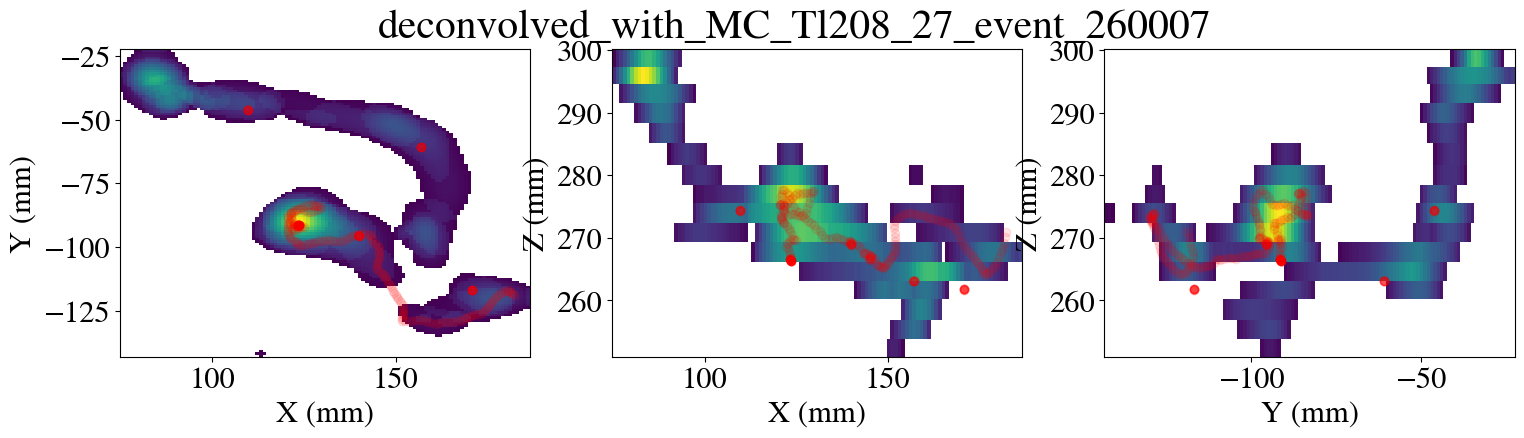

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits_deco.X.min(), hits_deco.X.max())
yy = np.arange(hits_deco.Y.min(), hits_deco.Y.max())
zz = hits_deco.Z.unique()

axes[0].hist2d(hits_deco.X, hits_deco.Y, bins=[xx, yy], weights=hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[0].scatter(xt, yt,  alpha=0.1, color='red')
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_deco.X, hits_deco.Z, bins=[xx, zz], weights=hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[1].scatter(xt, zt,  alpha=0.1, color='red')
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');

axes[2].hist2d(hits_deco.Y, hits_deco.Z, bins=[yy, zz], weights=hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[2].scatter(yt, zt,  alpha=0.1, color='red')
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');


fig.suptitle('deconvolved_with_MC_' + dir_name, fontsize=30)
#if lim_toggle == True:
#    axes[0].set_xlim([min_x - min_x/limit_spacing, max_x + max_x/limit_spacing])
#    axes[0].set_ylim([min_y - min_y/limit_spacing, max_y + min_y/limit_spacing])

#    axes[1].set_xlim([min_x - min_x/limit_spacing, max_x + min_x/limit_spacing])
#    axes[1].set_ylim([min_z - min_z/limit_spacing, max_z + min_z/limit_spacing])

#    axes[2].set_xlim([min_y - min_y/limit_spacing, max_y + min_y/limit_spacing])
#    axes[2].set_ylim([min_z - min_z/limit_spacing, max_z + min_z/limit_spacing])

    


In [ ]:
display(hits_deco)

,event,npeak,X,Y,Z,E,Xpeak,Ypeak
0,520014,0.0,149.675,-97.325,250.911511,0.000111,130.671205,-77.432837
1,520014,0.0,149.675,-96.325,250.911511,0.000144,130.671205,-77.432837
2,520014,0.0,149.675,-95.325,250.911511,0.000157,130.671205,-77.432837
3,520014,0.0,149.675,-94.325,250.911511,0.000144,130.671205,-77.432837
4,520014,0.0,149.675,-93.325,250.911511,0.000113,130.671205,-77.432837
...,...,...,...,...,...,...,...,...
8246,520014,0.0,85.675,-33.325,300.133017,0.000107,130.671205,-77.432837
8247,520014,0.0,86.675,-35.325,300.133017,0.000114,130.671205,-77.432837
8248,520014,0.0,86.675,-34.325,300.133017,0.000121,130.671205,-77.432837
8249,520014,0.0,86.675,-33.325,300.133017,0.000105,130.671205,-77.432837


In [ ]:
x = hits_deco.X
y = hits_deco.Y
z = hits_deco.Z
e = hits_deco.E

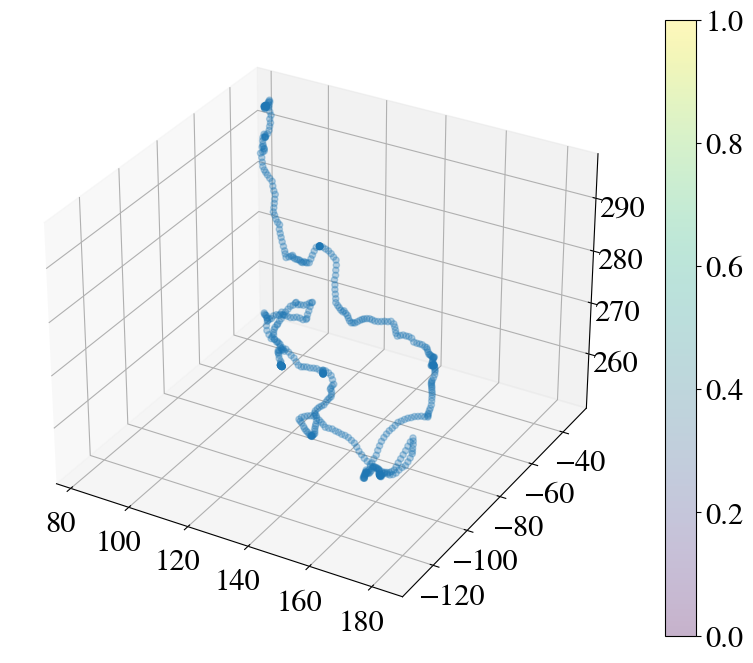

In [ ]:

x_MC = this_evt_true_info.x
y_MC = this_evt_true_info.y
z_MC = this_evt_true_info.z

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(x_MC, y_MC, z_MC, alpha=0.3, cmap='cool')
plt.colorbar(p)

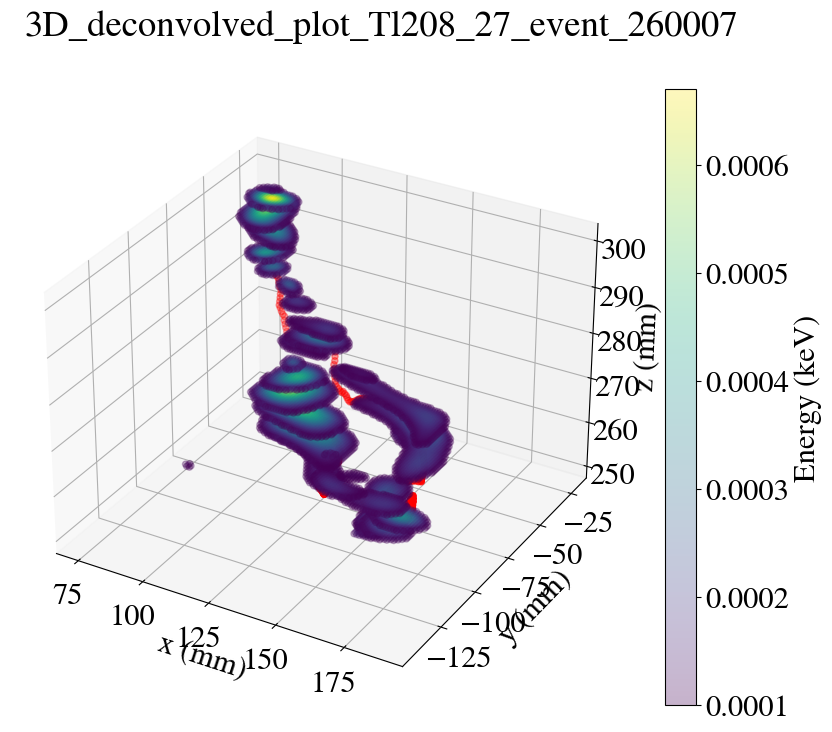

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
em = e > 0.00005
#p = ax.scatter(x[em], y[em], z[em], c=e[em], alpha=0.3, cmap='viridis')
p = ax.scatter(x, y, z, c=e, alpha=0.3, cmap='viridis', zorder=0.3)

cb = fig.colorbar(p, ax=ax)
cb.set_label('Energy (keV)')
ax.scatter(x_MC, y_MC, z_MC, color='red', zorder = 0.5)
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_zlabel('z (mm)')

fig.suptitle('3D_deconvolved_plot_' + dir_name)
#fig.savefig(pre_dir_name + dir_name +  "/3D_deconvolved_plot")

plt.show()

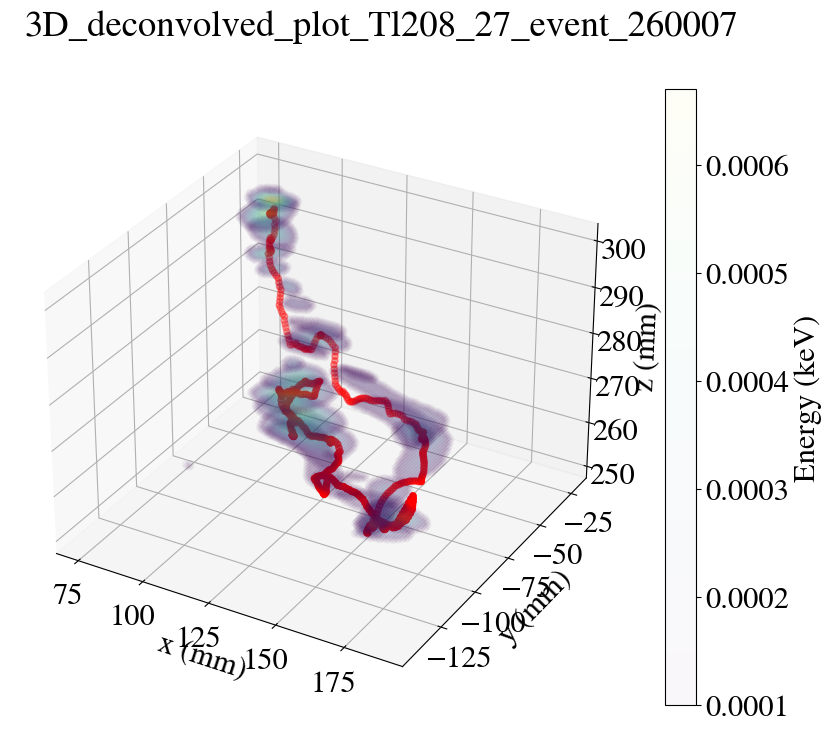

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
em = e# > 0.00005
#p = ax.scatter(x[em], y[em], z[em], c=e[em], alpha=0.3, cmap='viridis')
p = ax.scatter(x, y, z, c=e, alpha=0.03, cmap='viridis')

cb = fig.colorbar(p, ax=ax)
cb.set_label('Energy (keV)')
ax.scatter(x_MC, y_MC, z_MC, color='red')
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_zlabel('z (mm)')

fig.suptitle('3D_deconvolved_plot_' + dir_name)
#fig.savefig(pre_dir_name + dir_name +  "/3D_deconvolved_plot")

plt.show()

/tmp/ipykernel_11237/3572902639.py:56: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


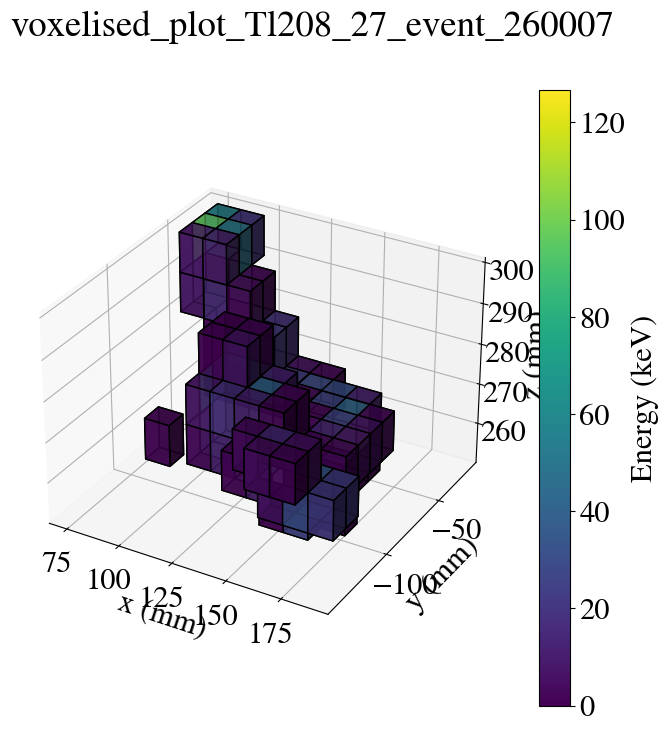

In [ ]:
base_vsize = 12 #mm
the_hits = []

xs = hits_deco.X
ys = hits_deco.Y
zs = hits_deco.Z
es = hits_deco.E

for x, y, z, e in zip(xs, ys, zs, es):
    if np.isnan(e): continue
    h = Hit(0, Cluster(0, xy(x,y), xy(0,0), 0), z, e*1000, xy(0,0))
    the_hits.append(h)

voxels = voxelize_hits(the_hits,
                       np.array([base_vsize, base_vsize, base_vsize]), False)

vsizex = voxels[0].size[0]
vsizey = voxels[0].size[1]
vsizez = voxels[0].size[2]

min_corner_x = min(v.X for v in voxels) - vsizex/2.
min_corner_y = min(v.Y for v in voxels) - vsizey/2.
min_corner_z = min(v.Z for v in voxels) - vsizez/2.

x = [np.round(v.X/vsizex) for v in voxels]
y = [np.round(v.Y/vsizey) for v in voxels]
z = [np.round(v.Z/vsizez) for v in voxels]
e = [v.E for v in voxels]

x_min = int(min(x))
y_min = int(min(y))
z_min = int(min(z))

x_max = int(max(x))
y_max = int(max(y))
z_max = int(max(z))

#print(f'X min = {x_min}, X max = {x_max}')
#print(f'Y min = {y_min}, Y max = {y_max}')
#print(f'Z min = {z_min}, Z max = {z_max}')

VOXELS = np.zeros((x_max-x_min+1, y_max-y_min+1, z_max-z_min+1))
#print(VOXELS.shape)

# sort through the event set the "turn on" the hit voxels
cmap = cm.viridis
norm = Normalize(vmin=0, vmax=max(e))

colors = np.empty(VOXELS.shape, dtype=object)
for q in range(0,len(z)):
    VOXELS[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = 1
    colors[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = cmap(norm(e[q]))

# and plot everything
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
#a,b,c is spacing in mm needs an extra dim
a,b,c = np.indices((x_max-x_min+2, y_max-y_min+2, z_max-z_min+2))
a = a*vsizex + min_corner_x
b = b*vsizey + min_corner_y
c = c*vsizez + min_corner_z

# a, b, c are the corners of the voxels
ax.voxels(a,b,c, VOXELS, facecolors=colors , edgecolor='k',alpha=0.8)

ax.set_xlabel('x (mm)')#,fontsize=16)
ax.set_ylabel('y (mm)')#,fontsize=16)
ax.set_zlabel('z (mm)')#,fontsize=16)


sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = fig.colorbar(sm)
cb.set_label('Energy (keV)')

fig.suptitle('voxelised_plot_' + dir_name)
plt.show()

In [ ]:
# make the tracks 
energy_threshold = 10
min_voxels = 3
(mod_voxels, dropped_voxels) = drop_end_point_voxels(voxels, energy_threshold, min_voxels)

In [ ]:
tracks = make_track_graphs(mod_voxels)
tracks = sorted(tracks, key=get_track_energy, reverse = True)

In [ ]:
display(tracks)

In [ ]:
for c, t in enumerate(tracks, 0):
    print("Track ID:")
    print(c)
    print("")
    print("Graph content:")
    print(t)

Track ID:
0

Graph content:
Graph with 90 nodes and 472 edges
Track ID:
1

Graph content:
Graph with 1 nodes and 0 edges


In [ ]:
display(tracks[0])